<h2><center>Artificial Intelligence, Assignment 2</center></h2>

<h3><center>Search agents</center></h3>

<img src='https://github.com/acosse/Artificial-Intelligence-Fall2021/blob/main/Assignments/Assignment2/imageAIAssignment002.jpeg?raw=1' width="400" height="400">


__Total:__ 27pts + 5pts

__Given date:__ Tuesday September 28

__Due date:__ Friday October 15

 = = = = = = = = = = = = = = = = = = = = = \
 **Name:** Haoming(Hammond) Liu \
 **NetID:** hl3797 \
 **Date:** Oct. 14th, 2021 \
  = = = = = = = = = = = = = = = = = = = = =


In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import display, HTML
from matplotlib.animation import FuncAnimation

### Question 1. A story of robots and batteries 

##### (15pts + 2pts)

We consider the simple 12$\times$12 world depicted below. In this first exercise, we will study the behavior of an agent that can only see the immediately adjacent cells (that is it only sees the cells that are directly in front, behind, or on its left/right). Your agent is a simple robot that enters the maze from the bottom left cell and must reach the exit which is located on the uppermost rightmost cell. 


<img src='https://github.com/acosse/Artificial-Intelligence-Fall2021/blob/main/Assignments/Assignment2/MAZE002.png?raw=1' width="400" height="400">

<p style="margin-bottom:1cm;"></p>

The objective of the agent is twofold:

   - 1) It has to find the exit (In a first approach, we won't take any step cost into account), while avoiding all the holes.

   - 2) It has to collect all the batteries. 


In [ ]:
# Shared Maze class with util functions

class Maze(object):
    def __init__(self, random_seed=0, maze_height=12, maze_width=12, \
                    battery_num=14, hole_num=18, info=False):

        # init attributes
        self.random_seed = random_seed
        self.battery_num = battery_num
        self.maze_height = maze_height
        self.maze_width = maze_width
        self.hole_num = hole_num
        
        # reset the random seed
        random.seed(random_seed)
        np.random.seed(random_seed)

        # print maze info
        if info:
            print('[Maze Init]: h=%d, w=%d, btry=%d, hole=%d.' % \
                (maze_height, maze_width, battery_num, hole_num))
        
        while True:
            # genrate a random maze
            maze_1d = [0 for i in range(maze_height * maze_width)]
            for i in range(battery_num):
                maze_1d[i] = 1
            for i in range(hole_num):
                maze_1d[battery_num+i] = -1
            random.shuffle(maze_1d)
            # # 1D maze test
            # print(maze_1d)
            # print(sum(maze_1d))

            # reshape to 2D as np array
            maze_2d = np.asarray(maze_1d).reshape(maze_height, maze_width)
            
            # make sure the entrance and the exit are both valid
            if (maze_2d[0, -1] == 0) and (maze_2d[-1, 0] == 0):
                break

        # preview the maze
        self.maze = maze_2d
        if info:
            print(self.maze)
    
    # re-define 'getitem' for convenience
    def __getitem__(self, key):
        return self.maze[key]
    
    # re-define 'setitem' for convenience
    def __setitem__(self, key, val):
        self.maze[key] = val

    # util fuction for q1.2 & q1.3
    def load_maze(self, maze, maze_height, maze_width, \
                    battery_num, hole_num):
        assert np.count_nonzero(maze == 1) == battery_num
        assert np.count_nonzero(maze == -1) == hole_num
        assert maze_height, maze_width == maze.shape
        self.battery_num = battery_num
        self.maze_height = maze_height
        self.maze_width = maze_width
        self.hole_num = hole_num
        self.maze = maze

    # get available actions at a given position
    #   - condition 1: within the bound of the maze
    #   - condition 2: not a wall (only for q1.2 & q1.3)
    def avail_actions(self, pos_h, pos_w):
        # all actions: left(l), right(r), up(u), down(d)
        avail_actions = []
        assert (0 <= pos_h <= self.maze_height-1)
        assert (0 <= pos_w <= self.maze_width-1)
        if (pos_w > 0) and (self.maze[pos_h, pos_w-1] != -2):
            avail_actions.append('l')
        if (pos_w < self.maze_width-1) and (self.maze[pos_h, pos_w+1] != -2):
            avail_actions.append('r')
        if (pos_h > 0) and (self.maze[pos_h-1, pos_w] != -2):
            avail_actions.append('u')
        if (pos_h < self.maze_height-1) and (self.maze[pos_h+1, pos_w] != -2):
            avail_actions.append('d')
        return avail_actions
    
    # get new pos after certain action
    def new_pos(self, pos_h, pos_w, action):
        assert (0 <= pos_h <= self.maze_height-1)
        assert (0 <= pos_w <= self.maze_width-1)
        if action == 'l':
            return pos_h, pos_w-1
        elif action == 'r':
            return pos_h, pos_w+1
        elif action == 'u':
            return pos_h-1, pos_w
        elif action == 'd':
            return pos_h+1, pos_w
        else:
            raise ValueError('Invalid action: %s' % action)
    
    # get prev pos before certain action
    def prev_pos(self, pos_h, pos_w, action):
        assert (0 <= pos_h <= self.maze_height-1)
        assert (0 <= pos_w <= self.maze_width-1)
        if action == 'l':
            return pos_h, pos_w+1
        elif action == 'r':
            return pos_h, pos_w-1
        elif action == 'u':
            return pos_h+1, pos_w
        elif action == 'd':
            return pos_h-1, pos_w
        else:
            raise ValueError('Invalid action: %s' % action)
    
    # get game status (running: True; end: False)
    def game_flag(self, pos_h, pos_w, curr_battery):
        assert (0 <= pos_h <= self.maze_height-1)
        assert (0 <= pos_w <= self.maze_width-1)
        exit_flag = (pos_h == 0) and (pos_w == self.maze_width-1)
        btry_falg = (curr_battery == self.battery_num)
        return not (exit_flag and btry_falg)


# test the Maze class
test_maze = Maze()
print('[Avail Actions at (0, 11)]:', test_maze.avail_actions(0, 11))
print('[Avail Actions at (11, 0)]:', test_maze.avail_actions(11, 0))
print('[Pos after [l] at (0, 11)]:', test_maze.new_pos(0, 11, 'l'))
print('[Pos after [d] at (0, 11)]:', test_maze.new_pos(0, 11, 'd'))
print('[Game Flag at (0, 11), btry=14]:', test_maze.game_flag(0, 11, 14))
print('[Game Flag at (11, 0), btry=0]:', test_maze.game_flag(11, 0, 0))

[Avail Actions at (0, 11)]: ['l', 'd']
[Avail Actions at (11, 0)]: ['r', 'u']
[Pos after [l] at (0, 11)]: (0, 10)
[Pos after [d] at (0, 11)]: (1, 11)
[Game Flag at (0, 11), btry=14]: False
[Game Flag at (11, 0), btry=0]: True


##### Question 1.1. (5pts) A simple reflex agent 

Using a simple while loop and follow the ideas discussed during the recitations to code a simple reflex agent that achieves this objective. When the agent faces a pit, it should avoid it. When the agent is on a cell containing a battery, it should collect it. Finally the agent can only move in the four immediately adjacent cells to its current position. When it sees no pit and there are no batteries in any of the adjacent cells, it should move at random. Consider adding on the order of 14 batteries and 18 holes (first manually, then at random)

In [ ]:
# Q1.1 - simple reflex agent

# create a random maze with the following cells
#   - nothing (0)
#   - battery (1)
#   - hole (-1)
maze = Maze(info=True)

# init start location
battery_count = 0
robot_h, robot_w = 11, 0
max_steps = 5000

# init logs
q11_action_log = []
q11_maze_log = [maze.maze.copy()]
q11_robot_log = [(robot_h, robot_w)]

# loop until the game is over
while maze.game_flag(robot_h, robot_w, battery_count):

    # first condition: collect the battery
    if maze[robot_h, robot_w] == 1:
        battery_count += 1
        q11_action_log.append('c')
        maze[robot_h, robot_w] = 0
        continue
    
    # second condition: take valid steps & avoid holes
    avail_actions = maze.avail_actions(robot_h, robot_w)
    valid_actions = []
    for action in avail_actions:
        new_idx = maze.new_pos(robot_h, robot_w, action)
        if maze[new_idx] != -1:
            valid_actions.append(action)
    
    # randomly select a valid action
    final_action = random.choice(valid_actions)
    robot_h, robot_w = maze.new_pos(robot_h, robot_w, final_action)
    
    # update to logs
    q11_action_log.append(final_action)
    q11_maze_log.append(maze.maze.copy())
    q11_robot_log.append((robot_h, robot_w))

    # exit as needed
    if len(q11_action_log) >= max_steps:
        break

print('[Action Log Length]:', len(q11_action_log))
# print('[Current Maze]:')
# print(maze.maze)
# print('[Diff]:')
# print(q11_maze_log[0] - maze.maze)

[Maze Init]: h=12, w=12, btry=14, hole=18.
[[ 0  0 -1  0  0  0  0  0  0  0  0  0]
 [ 0 -1  0  0  1  0 -1  1 -1  0  0  0]
 [-1  0 -1  0 -1  0  0  0  0  0  0 -1]
 [ 0 -1  0  0  0  0  0  0  0  1  0 -1]
 [ 0  0  1  0  0  0  0  0  0 -1  0  0]
 [ 0  1  0  0  0  0 -1  0  0  1  0  0]
 [ 0  0  0  0  0  0 -1 -1  0  0  1  0]
 [-1  0  0  0  1  0  0  0  0  0  1  1]
 [ 0  1  0  0  0  0  0 -1  0  0  0  0]
 [ 0  0  0  0  0  0  0  1  0  1  0 -1]
 [ 0  0  0  0  0  0  0  0 -1  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  1  0  0]]
[Action Log Length]: 1996


##### Question 1.2. (5pts) Search agent

We will now assume that our agent has a map of the world. On top of the pits from above, the world now also contains walls, which are additional obstacles in the search for the exit.

Solve the problem using Breadth First search. The children of a node are given by the adjacent cells. Once you have the path to a battery, stores it. Then continue BFS from the location of this battery and store your second path,.... Proceed like this until you have all the batteries. From the last battery find the exit.  

<img src='https://github.com/acosse/Artificial-Intelligence-Fall2021/blob/main/Assignments/Assignment2/Maze003.png?raw=1' width="400" height="400">

<p style="margin-bottom:1cm;"></p>



In [ ]:
# Q1.2 - search agent

# BFS for either battery or exit
def q12_breath_first_search(maze, pos_h, pos_w, goal='btry'):
    
    # init maze size & flag functions
    assert goal in ('btry', 'exit')
    maze_h, maze_w = maze.maze.shape
    btry_flag = lambda h, w: (maze[h, w] == 1)
    exit_flag = lambda h, w: (h == 0) and (w == maze_w-1)
    status_check = btry_flag if goal == 'btry' else exit_flag
    
    # init queue & visited dict for BFS
    queue = [(pos_h, pos_w, 's')]
    visited_dict = {(pos_h, pos_w): 's'}

    # start from the entrance
    h, w = pos_h, pos_w

    # checking goal status
    while not status_check(h, w):

        # check all valid actions
        h, w, _ = queue.pop(0)
        avail_actions = maze.avail_actions(h, w)

        # update queue and visited dict
        for action in avail_actions:
            new_idx = maze.new_pos(h, w, action)
            new_h, new_w = new_idx
            if (maze[new_idx] != -1) and (new_idx not in visited_dict):
                queue.append((new_h, new_w, action))
                visited_dict[new_idx] = action
        # print(queue)
        # print(visited_dict)
    
    # trace back the path to the start node
    path = [(h, w, visited_dict[(h, w)])]
    while path[-1][2] != 's':
        h, w, act = path[-1]
        prev_idx = maze.prev_pos(h, w, act)
        prev_h, prev_w = prev_idx
        path.append((prev_h, prev_w, visited_dict[prev_idx]))
    
    # reverse the path to the right order
    path = path[::-1]
    return path
    

# load a maze with the following cells
#   - nothing (0)
#   - battery (1)
#   - hole (-1)
#   - wall (-2)

# this is the sample maze in the image
sample_maze = np.asarray([
    [ 0,  0, -2,  1,  0,  0,  0,  1,  0,  0,  0,  0],
    [ 1,  0, -2,  0,  0,  0, -2,  0,  0, -2, -2, -2],
    [ 0,  0,  0,  0, -1,  0, -2,  0,  0,  1, -1,  0],
    [ 0, -1, -2, -2, -2,  0,  0, -1, -2,  0,  0,  0],
    [ 0,  0,  0, -1,  0,  1,  0,  0,  0, -1,  0,  1],
    [ 0, -2, -2, -2,  0,  0,  0, -2, -2,  0,  0,  0],
    [ 0,  0,  0,  1,  0,  0,  0,  0,  1,  0, -2, -2],
    [ 1,  0,  0,  0, -2, -2,  1,  0, -2,  0,  0,  0],
    [ 0,  0,  0,  0, -1,  0,  0,  0, -2,  0, -1,  0],
    [ 0, -1,  0,  0,  0,  0,  0, -1,  0,  0,  1,  0],
    [ 0, -2,  0, -1,  0,  1,  0, -2, -2, -1,  0,  0],
    [ 0, -2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]
])

# init maze
maze = Maze()
maze.load_maze(sample_maze, 12, 12, 12, 12)
print('[Loaded Maze]:')
print(maze.maze)

# init variables
battery_count = 0
robot_h, robot_w = 11, 0

# init logs
q12_action_log = [(11, 0, 's')]
q12_maze_log = [maze.maze.copy()]
q12_robot_log = [(robot_h, robot_w)]
print('\n[Path Log]:')

# step1: collect all the batteries
while battery_count < maze.battery_num:

    # find the path to a battery (BFS)
    path = q12_breath_first_search(maze, robot_h, robot_w, goal='btry')

    # store each step (for the movie)
    for h, w, a in path:
        q12_maze_log.append(maze.maze.copy())
        q12_robot_log.append((h, w))

    # update the state (pos, action_log, etc.)
    robot_h, robot_w, _ = path[-1]
    q12_action_log += path[1:]
    maze[robot_h, robot_w] = 0
    battery_count += 1
    print(path[1:])    

# step2: find the path to the exit
path = q12_breath_first_search(maze, robot_h, robot_w, goal='exit')
for h, w, a in path:
    q12_maze_log.append(maze.maze.copy())
    q12_robot_log.append((h, w))
robot_h, robot_w, _ = path[-1]
q12_action_log += path[1:]
print(path[1:])

# print('\n[Current Maze]:')
# print(maze.maze)
# print('\n[Diff]:')
# print(q12_maze_log[0] - maze.maze)
print('\n[Remaining Battery]:', np.count_nonzero(maze.maze == 1))
print('[Action Log Length]:', len(q12_action_log)-1)

[Loaded Maze]:
[[ 0  0 -2  1  0  0  0  1  0  0  0  0]
 [ 1  0 -2  0  0  0 -2  0  0 -2 -2 -2]
 [ 0  0  0  0 -1  0 -2  0  0  1 -1  0]
 [ 0 -1 -2 -2 -2  0  0 -1 -2  0  0  0]
 [ 0  0  0 -1  0  1  0  0  0 -1  0  1]
 [ 0 -2 -2 -2  0  0  0 -2 -2  0  0  0]
 [ 0  0  0  1  0  0  0  0  1  0 -2 -2]
 [ 1  0  0  0 -2 -2  1  0 -2  0  0  0]
 [ 0  0  0  0 -1  0  0  0 -2  0 -1  0]
 [ 0 -1  0  0  0  0  0 -1  0  0  1  0]
 [ 0 -2  0 -1  0  1  0 -2 -2 -1  0  0]
 [ 0 -2  0  0  0  0  0  0  0  0  0  0]]

[Path Log]:
[(10, 0, 'u'), (9, 0, 'u'), (8, 0, 'u'), (7, 0, 'u')]
[(7, 1, 'r'), (7, 2, 'r'), (7, 3, 'r'), (6, 3, 'u')]
[(6, 4, 'r'), (6, 5, 'r'), (6, 6, 'r'), (7, 6, 'd')]
[(7, 7, 'r'), (6, 7, 'u'), (6, 8, 'r')]
[(6, 7, 'l'), (6, 6, 'l'), (6, 5, 'l'), (5, 5, 'u'), (4, 5, 'u')]
[(3, 5, 'u'), (2, 5, 'u'), (1, 5, 'u'), (1, 4, 'l'), (1, 3, 'l'), (0, 3, 'u')]
[(0, 4, 'r'), (0, 5, 'r'), (0, 6, 'r'), (0, 7, 'r')]
[(0, 8, 'r'), (1, 8, 'd'), (2, 8, 'd'), (2, 9, 'r')]
[(3, 9, 'd'), (3, 10, 'r'), (3, 11, 'r'), (4, 11, 'd

##### Question 1.3. (5pts) Informed search agent

In this third question, we will use an informed search strategy to improve our agent. We want to use as our heuristic the $\ell_1$ distance to the closest battery that has not been picked. Code a Best First Search agent whose heuristic changes as it picks up new batteries. As soon as it picked up the last battery, the heuristic becomes the $\ell_1$ distance to the exit. You can assume that the cells have unitary side length. Also recall that the $\ell_1$ distance is given by $\|\boldsymbol x_1 - \boldsymbol x_2\|_1 = |x_{11} - x_{21}| + |x_{12} - x_{22}|$ where $\boldsymbol x_1 = (x_{11}, x_{12})$, $\boldsymbol x_{2} = (x_{21}, x_{22})$.    


<img src='https://github.com/acosse/Artificial-Intelligence-Fall2021/blob/main/Assignments/Assignment2/Maze003.png?raw=1' width="400" height="400">

<p style="margin-bottom:1cm;"></p>



In [ ]:
# find the closest battery by the heuristic function
def find_battery(maze, pos_h, pos_w):

    # find all battery positions
    pos_list = []
    maze_h, maze_w = maze.maze.shape
    for i in range(maze_h):
        for j in range(maze_w):
            if maze[i, j] == 1:
                pos_list.append((i, j, pos_h, pos_w))
    
    # choose the best one based on heur_func
    heur_func = lambda tp: abs(tp[0]-tp[2]) + abs(tp[1]-tp[3])
    return min(pos_list, key=heur_func)

# BFS with given dst position
def q13_breath_first_search(maze, pos_h, pos_w, dst_h, dst_w):
    
    # goal status
    status_check = lambda h, w: (h == dst_h) and (w == dst_w)
    
    # init queue & visited dict
    queue = [(pos_h, pos_w, 's')]
    visited_dict = {(pos_h, pos_w): 's'}

    # main loop
    h, w = pos_h, pos_w
    while not status_check(h, w):

        # check all valid actions
        h, w, _ = queue.pop(0)
        avail_actions = maze.avail_actions(h, w)

        # update queue & visited dict
        for action in avail_actions:
            new_idx = maze.new_pos(h, w, action)
            new_h, new_w = new_idx
            if (maze[new_idx] != -1) and (new_idx not in visited_dict):
                queue.append((new_h, new_w, action))
                visited_dict[new_idx] = action
        # print(queue)
        # print(visited_dict)
    
    # trace back the path to the start node
    path = [(h, w, visited_dict[(h, w)])]
    while path[-1][2] != 's':
        h, w, act = path[-1]
        prev_idx = maze.prev_pos(h, w, act)
        prev_h, prev_w = prev_idx
        path.append((prev_h, prev_w, visited_dict[prev_idx]))

    # reverse the path to the right order
    path = path[::-1]
    return path

# this is the sample maze in the image
sample_maze = np.asarray([
    [ 0,  0, -2,  1,  0,  0,  0,  1,  0,  0,  0,  0],
    [ 1,  0, -2,  0,  0,  0, -2,  0,  0, -2, -2, -2],
    [ 0,  0,  0,  0, -1,  0, -2,  0,  0,  1, -1,  0],
    [ 0, -1, -2, -2, -2,  0,  0, -1, -2,  0,  0,  0],
    [ 0,  0,  0, -1,  0,  1,  0,  0,  0, -1,  0,  1],
    [ 0, -2, -2, -2,  0,  0,  0, -2, -2,  0,  0,  0],
    [ 0,  0,  0,  1,  0,  0,  0,  0,  1,  0, -2, -2],
    [ 1,  0,  0,  0, -2, -2,  1,  0, -2,  0,  0,  0],
    [ 0,  0,  0,  0, -1,  0,  0,  0, -2,  0, -1,  0],
    [ 0, -1,  0,  0,  0,  0,  0, -1,  0,  0,  1,  0],
    [ 0, -2,  0, -1,  0,  1,  0, -2, -2, -1,  0,  0],
    [ 0, -2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]
])

# init maze
maze = Maze()
maze.load_maze(sample_maze, 12, 12, 12, 12)
print('[Loaded Maze]:')
print(maze.maze)

# init variables
battery_count = 0
robot_h, robot_w = 11, 0

# init logs
q13_action_log = [(11, 0, 's')]
q13_maze_log = [maze.maze.copy()]
q13_robot_log = [(robot_h, robot_w)]
print('\n[Path Log]:')

# step1: collect all the batteries
while battery_count < maze.battery_num:

    # choose the best battery for next step
    btry_h, btry_w, _, _ = find_battery(maze, robot_h, robot_w)

    # find the path to this battery (BFS)
    path = q13_breath_first_search(maze, robot_h, robot_w, btry_h, btry_w)
    
    # store each step (for the movie)
    for h, w, a in path:
        q13_maze_log.append(maze.maze.copy())
        q13_robot_log.append((h, w))

    # update the state (pos, action_log, etc.)
    robot_h, robot_w, _ = path[-1]
    q13_action_log += path[1:]
    maze[robot_h, robot_w] = 0
    battery_count += 1
    print(path[1:])

# step2: find the path to the exit
path = q13_breath_first_search(maze, robot_h, robot_w, 0, 11)
for h, w, a in path:
    q13_maze_log.append(maze.maze.copy())
    q13_robot_log.append((h, w))
robot_h, robot_w, _ = path[-1]
q13_action_log += path[1:]
print(path[1:])

# print('\n[Current Maze]:')
# print(maze.maze)
# print('\n[Diff]:')
# print(q13_maze_log[0] - maze.maze)
print('\n[Remaining Battery]:', np.count_nonzero(maze.maze == 1))
print('[Action Log Length]:', len(q13_action_log)-1)

[Loaded Maze]:
[[ 0  0 -2  1  0  0  0  1  0  0  0  0]
 [ 1  0 -2  0  0  0 -2  0  0 -2 -2 -2]
 [ 0  0  0  0 -1  0 -2  0  0  1 -1  0]
 [ 0 -1 -2 -2 -2  0  0 -1 -2  0  0  0]
 [ 0  0  0 -1  0  1  0  0  0 -1  0  1]
 [ 0 -2 -2 -2  0  0  0 -2 -2  0  0  0]
 [ 0  0  0  1  0  0  0  0  1  0 -2 -2]
 [ 1  0  0  0 -2 -2  1  0 -2  0  0  0]
 [ 0  0  0  0 -1  0  0  0 -2  0 -1  0]
 [ 0 -1  0  0  0  0  0 -1  0  0  1  0]
 [ 0 -2  0 -1  0  1  0 -2 -2 -1  0  0]
 [ 0 -2  0  0  0  0  0  0  0  0  0  0]]

[Path Log]:
[(10, 0, 'u'), (9, 0, 'u'), (8, 0, 'u'), (7, 0, 'u')]
[(7, 1, 'r'), (7, 2, 'r'), (7, 3, 'r'), (6, 3, 'u')]
[(6, 4, 'r'), (6, 5, 'r'), (5, 5, 'u'), (4, 5, 'u')]
[(4, 6, 'r'), (5, 6, 'd'), (6, 6, 'd'), (7, 6, 'd')]
[(7, 7, 'r'), (6, 7, 'u'), (6, 8, 'r')]
[(6, 9, 'r'), (5, 9, 'u'), (5, 10, 'r'), (4, 10, 'u'), (3, 10, 'u'), (3, 9, 'l'), (2, 9, 'u')]
[(2, 8, 'l'), (2, 7, 'l'), (1, 7, 'u'), (0, 7, 'u')]
[(0, 6, 'l'), (0, 5, 'l'), (0, 4, 'l'), (0, 3, 'l')]
[(1, 3, 'd'), (2, 3, 'd'), (2, 2, 'l'), (2, 1, 'l

##### Bonus (2pts) 
Generate and display the movie of the search for each of the questions above.

##### References:
[matplotlib animation api](https://matplotlib.org/stable/api/animation_api.html) \
[display animation in jupyter notebook](https://www.jianshu.com/p/9894d6086573)

In [ ]:
# Q1 Bonus - Animation

log_dict = {
    # question_id: (maze_log, robot_log, frame_delay)
    '1.1': (q11_maze_log, q11_robot_log, 1),
    '1.2': (q12_maze_log, q12_robot_log, 5),
    '1.3': (q13_maze_log, q13_robot_log, 5)   
}

def display_movie(key):

    # plot a new frame
    def animate(frame_idx):
        plot.set_data(convert_maze(frame_idx, log_dict[key]))
        return (plot, )

    # init matrix plot
    fig, ax = plt.subplots()
    plot = ax.matshow(convert_maze(0, log_dict[key]), cmap=plt.cm.Set2)

    # make animation
    frames = len(log_dict[key][0]) * log_dict[key][2]
    anim = FuncAnimation(fig, animate, frames=frames, interval=30, blit=True)
    display(HTML(anim.to_html5_video()))
    fig.delaxes(ax)

def convert_maze(frame_idx, logs):

    # init logs and params
    maze_log, robot_log, delay = logs
    idx = frame_idx // delay

    # re-color the maze
    plot_maze = maze_log[idx].copy()
    plot_maze[plot_maze == 0] = 8
    plot_maze[plot_maze == 1] = 1
    plot_maze[plot_maze == -1] = 2
    plot_maze[plot_maze == -2] = 7
    plot_maze[robot_log[idx]] = 3
    return plot_maze

# create and display the movie
# Note: 1.1 animation needs about 2 mins to process
display_movie('1.2')

<Figure size 432x288 with 0 Axes>

### Question 2. Rook Jumping

##### (12pts + 3pts)

In this second question, we consider a "rook jumping" maze. An example of such a maze is given below (the starting position is shown in red and the goal position is shown in green). 



<img src='https://github.com/acosse/Artificial-Intelligence-Fall2021/blob/main/Assignments/Assignment2/RookMaze001.png?raw=1' width="350" height="350">

Each state in the maze has an associated jump number that provides the exact number of cells one may move horizontally or vertically in a straight line to change state. As an example, in the maze above, the first move may either be 2 cells on the right of (0,0) or 2 cells down to (2,0).

#### Question 2.1. Generate the maze (2pts)

Start by completing the function Maze_generation which takes as argument the dimension of the maze as well as a maximum jump number (don't take it much larger than n/2) and returns a matrix of random integers between 0 and the maximum jump length. 

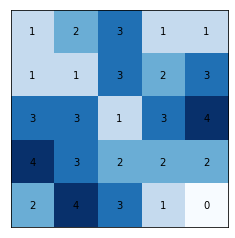

In [ ]:
from random import randint

# generate a valid jump num at given position
def valid_jump_num(n, max_jump_num, i, j):
    max_jump_h = min(max(i, n-i-1), max_jump_num)
    max_jump_w = min(max(j, n-j-1), max_jump_num)
    return randint(1, max(max_jump_h, max_jump_w))

# generate a random rook jumping maze
def Maze_generation(n, max_jump_num=None):
    '''function should return a random maze'''

    # by default, all valid jumps are allowed
    if max_jump_num is None:
        max_jump_num = n-1
    
    # generate a random maze
    maze = np.zeros((n, n), dtype=np.uint8)
    for i in range(n):
        for j in range(n):
            maze[i, j] = valid_jump_num(n, max_jump_num, i, j)

    # set the exit to 0
    maze[-1, -1] = 0

    return maze

def display_jump_maze(maze):
    h, w = maze.shape
    fig, ax = plt.subplots()
    ax.matshow(maze, cmap=plt.cm.Blues)
    for i in range(h):
        for j in range(w):
            ax.text(i, j, str(maze[j, i]), va='center', ha='center')
    ax.set_xticks([]) 
    ax.set_xticklabels([]) 
    ax.set_yticks([]) 
    ax.set_yticklabels([]) 
    plt.show()

display_jump_maze(Maze_generation(5))

##### Question 2.2. (5pts) Maze Evaluation

We now want to solve the maze (or equivalently, make sure it has a solution)  

Using _Breadth First Search_ (start with a reasonably small maze, e.g. 5 by 5), compute the minimum distance (depth number of moves) to each cell from the start cell (take the start cell to be the _uppermost leftmost_ cell). For this, keep track of a list of the depth distances to each node and update this list each time you encounter the corresponding node. Once BFS completed, return the minimum element from the list. 

Finally return the negative of the minimmum length of the path from the start to the goal and a large positive number (e.g. 1e6) if there is no such path.


In [ ]:
# return valid moves given curr_pos and step
def valid_pos(n, i, j, step):
    valid_moves = []
    if 0 <= i-step < n:
        valid_moves.append((i-step, j))
    if 0 <= i+step < n:
        valid_moves.append((i+step, j))
    if 0 <= j-step < n:
        valid_moves.append((i, j-step))
    if 0 <= j+step < n:
        valid_moves.append((i, j+step))
    return valid_moves
    
def Maze_Evaluation(maze):
    
    '''The function takes a maze (random n x n array of integers)
    and should return the the minimum 
    distances of the start node to the goal'''
    
    # init variables
    n, _ = maze.shape
    queue = [(0, 0)]
    dist_dict = {(0, 0): 0}
    update_count = 0

    # BFS
    while len(queue) > 0:

        # check valid steps
        h, w = queue.pop(0)
        curr_pos = (h, w)
        step = maze[curr_pos]
        valid_pos_list = valid_pos(n, h, w, step)

        # check all valid moves
        for next_pos in valid_pos_list:
            update_flag = False
            # case 1: first visit
            if next_pos not in dist_dict:
                update_flag = True
            # case 2: a better solution
            elif dist_dict[curr_pos] + step < dist_dict[next_pos]:
                update_flag = True
            # update dist_dict (if needed)
            if update_flag:
                dist_dict[next_pos] = dist_dict[curr_pos] + step
                queue.append(next_pos)
                update_count += 1

    # # print for testing
    # print('\n[Update Count]:', update_count)
    # for k, v in dist_dict.items():
    #     print(k, v)

    # eval function
    goal_pos = (n-1, n-1)
    eval_val = -dist_dict[goal_pos] if goal_pos in dist_dict else 1e6
    return int(eval_val)

# testing
test_maze = Maze_generation(7)
print('[Maze]:')
print(test_maze)
print('[Eval]:', Maze_Evaluation(test_maze))

[Maze]:
[[2 3 3 3 3 6 1]
 [3 5 1 1 3 2 2]
 [5 3 3 4 2 3 1]
 [4 2 1 2 2 5 6]
 [1 3 4 3 3 4 1]
 [1 5 4 4 3 3 1]
 [4 1 6 4 4 1 0]]
[Eval]: -12


##### Question 2.3. (5pts) Stochastic local search (Hill climbing)

Now that we have a way of representing each maze, we will try to improve our maze with a stochastic local search. In this question, each state in our graph will encode a whole maze. Our local search algorithm will work as follows

- For a random, non goal cell, change the jump number to a different random legal jump number

- Re-evaluate the start to goal distance according to the _Maze_Evaluation_ function that you implemented in Question 2.2.

- If the objective function has not increased, accept the change and store the new maze if its evaluation is the best evaluated so far. Otherwise, reject the change and revert the cell to its previous jump number

Perform a few iterations of Stochastich HC and return the RJM with the best (minimum) objective function

In [ ]:
def Maze_improvement(maze_init, maxIter):
    
    '''The function takes an initial Rook Jumping maze and 
    a maximum number of iterations as an input and returns 
    the improvement of the original maze obtained 
    through maxIter iteration of Stochastic Hill Descent'''
    
    # init variables
    n, _ = maze_init.shape
    best_maze, best_eval = maze_init, Maze_Evaluation(maze_init)

    # main loop
    for i in range(maxIter):
        # choose a non-goal cell & adjust jump number
        iprv_maze = best_maze.copy()
        rand_num = random.choice(list(range(n ** 2 - 1)))
        rand_pos = (rand_num // n), (rand_num % n)
        iprv_maze[rand_pos] = valid_jump_num(n, n-1, *rand_pos)
        # re-evaluate the modified maze
        iprv_eval = Maze_Evaluation(iprv_maze)
        if iprv_eval <= best_eval:
            best_maze, best_eval = iprv_maze, iprv_eval
    
    return best_maze, best_eval 

test_maze = Maze_generation(7)
print('[Maze]:')
print(test_maze)
print('[Eval]:', Maze_Evaluation(test_maze))

iprv_maze, iprv_eval = Maze_improvement(test_maze, maxIter=1000)
print('\n[Iprv Maze]:')
print(iprv_maze)
print('[Iprv Eval]:', iprv_eval)

[Maze]:
[[3 6 6 2 2 6 5]
 [4 1 1 1 2 2 1]
 [4 1 1 4 3 4 4]
 [5 2 4 1 3 2 3]
 [5 2 4 2 3 1 1]
 [6 1 5 4 2 1 4]
 [4 3 2 6 1 2 0]]
[Eval]: -16

[Iprv Maze]:
[[3 6 6 2 2 6 6]
 [5 2 2 4 5 3 1]
 [5 4 4 4 3 3 6]
 [5 3 2 3 4 5 6]
 [6 4 2 3 3 3 5]
 [6 4 3 1 3 5 2]
 [2 4 1 4 6 6 0]]
[Iprv Eval]: -88


##### Bonus (3pts) Random Restart

One problem with pure hill descent is that stochastic local search may become trapped in local minima. A possible escape strategy is to restart the search periodically. Another way of viewing this is that we iteratively perform pure hill descent, starting each descent at a random state. The end result is the best result from all descents.

Add Random Restart to your 'Maze_improvement' function.

In [ ]:
def Maze_improvement_RR(maze_init, max_iter_SHD, max_iter_RR):
    
    '''The function takes an initial (random) Rook Jumping maze and 
    a maximum number of iterations as an input and evaluates 
    the improvement of the original maze obtained 
    through max_iter_SHD iterations of Stochastic Hill Descent. 
    This process is repeated max_iter_RR times 
    (with different random initializations) and each of the 
    obtained solutions are stored. The max_iter_RR solutions are finally compared in 
    terms of the cost between the start and the goal node and 
    the best solution is returned as the final output'''
    
    # store the results of all RRs
    SHD_log = [(maze_init, Maze_Evaluation(maze_init))]

    # main loop for RR
    for i in range(max_iter_RR):
        # set different random seed
        random.seed(i)
        np.random.seed(i)
        SHD_log.append(Maze_improvement(maze_init, max_iter_SHD))

    # for i in range(len(SHD_log)):
    #     print('[Maze %d]: %d' % (i, SHD_log[i][1]))
    #     print(SHD_log[i][0])
    return min(SHD_log, key=lambda x: x[1])

test_maze = Maze_generation(7)
print('[Maze]:')
print(test_maze)
print('[Eval]:', Maze_Evaluation(test_maze))

res = Maze_improvement_RR(test_maze, max_iter_SHD=1000, max_iter_RR=20)
print('\n[Iprv RR Maze]:')
print(res[0])
print('[Iprv RR Eval]:', res[1])

[Maze]:
[[3 3 2 3 1 5 5]
 [4 1 3 5 1 5 1]
 [5 2 4 1 2 3 1]
 [5 2 2 3 2 4 2]
 [5 4 3 2 3 3 5]
 [2 2 4 3 2 3 5]
 [6 1 1 6 3 3 0]]
[Eval]: -28

[Iprv RR Maze]:
[[3 5 2 3 4 6 5]
 [6 5 4 3 3 4 3]
 [5 3 4 3 3 4 6]
 [6 5 1 3 3 5 6]
 [4 4 2 3 3 4 3]
 [5 5 5 2 1 4 6]
 [6 6 5 6 4 3 0]]
[Iprv RR Eval]: -120
